In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.torch_version
import torchvision.transforms as transforms
from PIL import Image
from torchsummary import summary
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall

In [4]:
class CustomDataset(Dataset):
    def __init__(self, labels_file, imgs_dir, transform=None):
        self.labels = pd.read_csv(labels_file)
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.mean_of_color_channels = None  # Initialize as None
        self.std_of_color_channels = None   # Initialize as None
        self._calculate_stats()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.labels.iloc[idx, 1]

        # Calculate mean and standard deviation if not already done
        if self.mean_of_color_channels is None or self.std_of_color_channels is None:
            self._calculate_stats()

        # Apply transformation with calculated statistics
        if self.transform:
            image = self.transform(image)

        return image, label

    def _calculate_stats(self):
        # Calculate mean and standard deviation across all images in the dataset
        # (consider using a random subset for efficiency with large datasets)
        channels_sum, channels_squared_sum = np.zeros(3), np.zeros(3)
        for idx in range(len(self)):
            img_path = os.path.join(self.imgs_dir, self.labels.iloc[idx, 0])
            image = np.asarray(Image.open(img_path).convert("RGB"))
            # Convert to float for calculations
            image = image.astype(np.float32)

            # Update channel sums and squared sums
            channels_sum += np.sum(image, axis=(0, 1))
            channels_squared_sum += np.sum(image**2, axis=(0, 1))

        # Calculate mean and standard deviation
        num_images = len(self)
        self.mean_of_color_channels = channels_sum / (num_images * image.shape[0] * image.shape[1])
        self.std_of_color_channels = np.sqrt(channels_squared_sum / (num_images * image.shape[0] * image.shape[1]) - self.mean_of_color_channels**2)


In [5]:
training_dataset = CustomDataset('data/Train/Train.csv', 'data/Train/')
validation_dataset = CustomDataset('data/Valid/Validation.csv', 'data/Valid/')
test_dataset = CustomDataset('data/Test/Test.csv', 'data/Test/')

In [6]:
print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 1569
Validation dataset size: 393
Test dataset size: 219


In [7]:
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
def imshow(img):
    plt.imshow(img)
    plt.show()

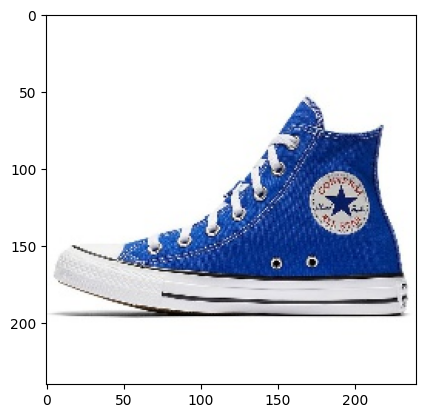

In [9]:
tst_img = validation_dataset.__getitem__(0)[0]
imshow(tst_img)

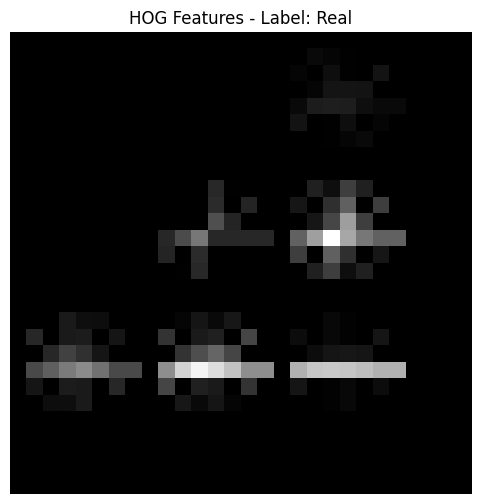

In [10]:
img_array = np.array(tst_img)
img_resized = cv2.resize(img_array, (28, 28))
# Convert image to grayscale
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
hog_feature, hog_image =hog(img_gray, 
                            visualize=True)
# Display the HOG image
plt.figure(figsize=(8, 6))
plt.imshow(hog_image, cmap='gray')
label = 'Real' if validation_dataset.__getitem__(0)[1] == 0 else 'AI Generated'
plt.title(f'HOG Features - Label: {label}')
plt.axis('off')
plt.show()

In [11]:
def extract_features(dataset):
    features = []
    labels = []
    for img, label in dataset:
        img_resized = cv2.resize(np.array(img), (28, 28))
        # Convert image to grayscale
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        # Calculate HOG features
        features.append(hog(img_gray, 
                            orientations=9, 
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), 
                            visualize=False))
        labels.append(label)
        
    return np.array(features), np.array(labels)

In [12]:
X_train, y_train = extract_features(training_dataset)
X_valid, y_valid = extract_features(validation_dataset)
X_test, y_test = extract_features(test_dataset)

In [13]:
print(f"Training feature shape:{X_train.shape}, Validation feature shape:{X_valid.shape}, Test feature shape:{X_test.shape}")
print(f"Training labels shape:{y_train.shape}, Validation labels shape:{y_valid.shape}, Test labels shape:{y_test.shape}")

Training feature shape:(1569, 144), Validation feature shape:(393, 144), Test feature shape:(219, 144)
Training labels shape:(1569,), Validation labels shape:(393,), Test labels shape:(219,)


# **KNN**

In [14]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'metric': ['euclidean', 'manhattan','cosine'],}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid, cv=5)
knn_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {knn_grid_search.best_params_}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11}


In [15]:
best_knn = knn_grid_search.best_estimator_
best_knn.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=11)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_knn_pred = best_knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_precision = precision_score(y_test, y_knn_pred)
knn_recall = recall_score(y_test, y_knn_pred)
print(f"KNN accuracy: {knn_accuracy}")
print(f"KNN precision: {knn_precision}")
print(f"KNN recall: {knn_recall}")

KNN accuracy: 0.8082191780821918
KNN precision: 0.7640449438202247
KNN recall: 1.0


## **SVM**

In [17]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [2, 3, 4, 5]}

svc = SVC()

svc_grid_search = GridSearchCV(svc, param_grid)

svc_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {svc_grid_search.best_params_}")

Best parameters: {'C': 0.1, 'degree': 3, 'kernel': 'poly'}


In [18]:
best_svc = svc_grid_search.best_estimator_
# best_svc = SVC()
best_svc.fit(X_train, y_train)

SVC(C=0.1, kernel='poly')

In [19]:

y_svc_pred = best_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_svc_pred)
svc_precision = precision_score(y_test, y_svc_pred)
svc_recall = recall_score(y_test, y_svc_pred)
print(f"SVC accuracy: {svc_accuracy}")
print(f"SVC precision: {svc_precision}")
print(f"SVC recall: {svc_recall}")

SVC accuracy: 0.8584474885844748
SVC precision: 0.8620689655172413
SVC recall: 0.9191176470588235


## **Naive Bayes**

In [20]:
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

nb = GaussianNB()

nb_grid_search = GridSearchCV(nb, param_grid)

nb_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {nb_grid_search.best_params_}")

Best parameters: {'var_smoothing': 1e-09}


In [21]:
best_nb = nb_grid_search.best_estimator_
# best_nb = GaussianNB()
best_nb.fit(X_train, y_train)

GaussianNB()

In [22]:

y_nb_pred = best_nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_nb_pred)
nb_precision = precision_score(y_test, y_nb_pred)
nb_recall = recall_score(y_test, y_nb_pred)
print(f"Naive Bayes accuracy: {nb_accuracy}")
print(f"Naive Bayes precision: {nb_precision}")
print(f"Naive Bayes recall: {nb_recall}")

Naive Bayes accuracy: 0.821917808219178
Naive Bayes precision: 0.8439716312056738
Naive Bayes recall: 0.875


## **Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']}

lr = LogisticRegression()

lr_grid_search = GridSearchCV(lr, param_grid)

lr_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {lr_grid_search.best_params_}")

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [24]:
best_lr = lr_grid_search.best_estimator_
# best_lr = LogisticRegression()
best_lr.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [25]:

y_lr_pred = best_lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_precision = precision_score(y_test, y_lr_pred)
lr_recall = recall_score(y_test, y_lr_pred)
print(f"Logistic Regression accuracy: {lr_accuracy}")
print(f"Logistic Regression precision: {lr_precision}")
print(f"Logistic Regression recall: {lr_recall}")

Logistic Regression accuracy: 0.863013698630137
Logistic Regression precision: 0.863013698630137
Logistic Regression recall: 0.9264705882352942


## **Decision Tree**

In [26]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],}

dt = DecisionTreeClassifier()

dt_grid_search = GridSearchCV(dt, param_grid)

dt_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {dt_grid_search.best_params_}")
                

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [27]:
best_dt = dt_grid_search.best_estimator_
# best_dt = DecisionTreeClassifier()
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=5)

In [28]:

y_dt_pred = best_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_dt_pred)
dt_precision = precision_score(y_test, y_dt_pred)
dt_recall = recall_score(y_test, y_dt_pred)
print(f"Decision Tree accuracy: {dt_accuracy}")
print(f"Decision Tree precision: {dt_precision}")
print(f"Decision Tree recall: {dt_recall}")

Decision Tree accuracy: 0.7853881278538812
Decision Tree precision: 0.7602339181286549
Decision Tree recall: 0.9558823529411765


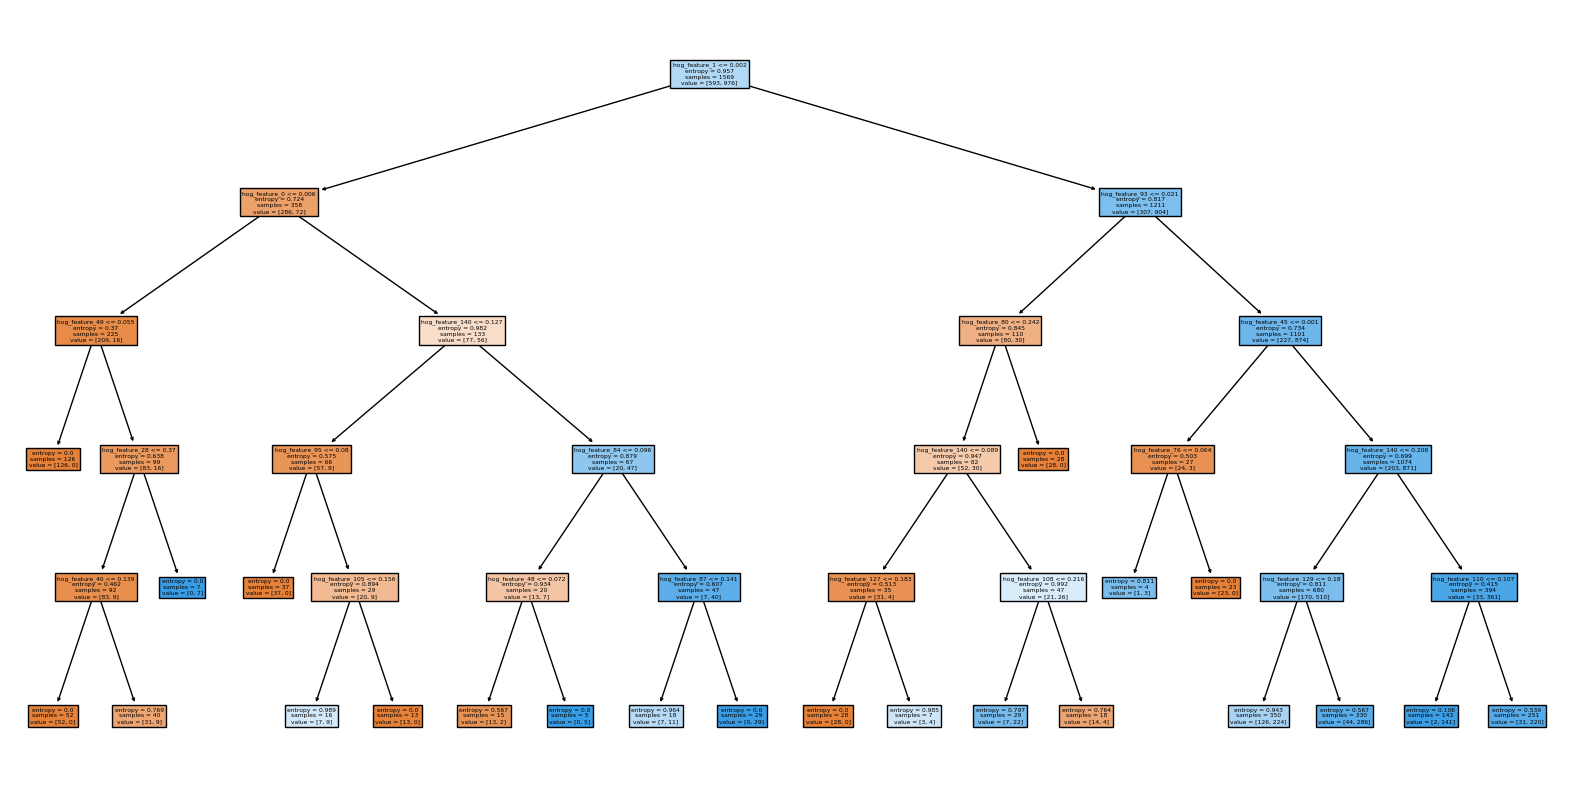

In [29]:
#print tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))

plot_tree(best_dt, filled=True, feature_names=['hog_feature_{}'.format(i) for i in range(X_train.shape[1])])
plt.show()


## **Random Forest**

In [30]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [50,80, 100],
              'max_depth': [ 5, 10, 15, 20],
              'max_features':[0.5, 0.7, 1.0],
              'min_samples_split': [2, 5, 10],}

rf = RandomForestClassifier(n_jobs=-1,random_state=42)

rf_grid_search = GridSearchCV(rf, param_grid)

rf_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {rf_grid_search.best_params_}")


Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_split': 10, 'n_estimators': 80}


In [31]:
best_rf = rf_grid_search.best_estimator_
# best_rf = RandomForestClassifier(n_jobs=-1)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=0.5, min_samples_split=10,
                       n_estimators=80, n_jobs=-1, random_state=42)

In [32]:

y_rf_pred = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_precision = precision_score(y_test, y_rf_pred)
rf_recall = recall_score(y_test, y_rf_pred)
print(f"Random Forest accuracy: {rf_accuracy}")
print(f"Random Forest precision: {rf_precision}")
print(f"Random Forest recall: {rf_recall}")


Random Forest accuracy: 0.8447488584474886
Random Forest precision: 0.8445945945945946
Random Forest recall: 0.9191176470588235


## **CNN**

In [33]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [34]:
# HyperParameters
dimension = 50
batch_size = 64

mean_of_color_channels = tuple(item / 255 for item in [131.8612, 121.9361, 116.0298])
std_of_color_channels = tuple(item / 255 for item in [88.6042, 87.0262, 87.3879])


train_transform = transforms.Compose([ 
    transforms.Resize((dimension, dimension)),
    transforms.ToTensor(),
    transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

test_transform = transforms.Compose([
    transforms.Resize((dimension, dimension)),
    transforms.ToTensor(),
    transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

In [35]:
cnn_training_dataset = CustomDataset('data/Train/Train.csv', 'data/Train/', transform=train_transform)
cnn_validation_dataset = CustomDataset('data/Valid/Validation.csv', 'data/Valid/', transform=test_transform)
cnn_testing_dataset = CustomDataset('data/Test/Test.csv', 'data/Test/', transform=test_transform)

In [36]:
cnn_training_loader = DataLoader(cnn_training_dataset, batch_size=batch_size, shuffle=True)
cnn_validation_loader = DataLoader(cnn_validation_dataset, batch_size=batch_size, shuffle=False)
cnn_testing_loader = DataLoader(cnn_testing_dataset, batch_size=batch_size, shuffle=False)

In [37]:
class Model(nn.Module):
    def __init__(self,num_classes,device,dim = 32,num_epochs = 20,learning_rate = 0.001,early_stopping = False):
        super().__init__()
        self.num_of_classes = num_classes
        self.device = device
        self.dim = dim
        # Debugging
        self.DEBUG = False
        # Hyperparameters
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        # History while Training
        self.model_loss_history = []
        self.model_train_acc_history = []
        self.model_val_acc_history = []
        self.model_val_precision_history = []
        self.model_val_recall_history = []
        self.model_lr_history = []

        # Model Attributes
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self.accuracy = Accuracy(task= 'multiclass', num_classes=self.num_of_classes, average='macro').to(self.device)
        self.precision = Precision(task= 'multiclass', num_classes=self.num_of_classes, average='macro').to(self.device)
        self.recall = Recall(task= 'multiclass', num_classes=self.num_of_classes, average='macro').to(self.device)
        # Model Architecture
        self.feature_extract = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(            
            nn.Linear(20000, self.num_of_classes),
        )
        
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x
    
    def predict(self, img):
        '''
        returns the predicted classes for the given images
        '''
        self.eval()
        with torch.no_grad():
            img = img.to(self.device)
            output = self(img)
            _, predicted = torch.max(output, 1)
            return predicted
        

    
    def eval_val(self, data_loader):
        '''
        returns accuracy, precision and recall
        '''
        self.eval()
        with torch.no_grad():
            for images, labels in data_loader:
                
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                self.accuracy(outputs, labels)
                self.precision(outputs, labels)
                self.recall(outputs, labels)

        return self.accuracy.compute(), self.precision.compute(), self.recall.compute()
    
    def train_model(self, train_loader, val_loader):
        
        last_accuracy = -100
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):

                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i%100 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall = self.eval_val(val_loader)
            train_acc, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])
            
            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall}')
            
            if val_acc > last_accuracy:
                last_accuracy = val_acc
            elif self.early_stopping:
                break
        
        print('Finished Training')

    def plot_history(self):
        # making two plots one for loss and other for accuracy
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Model Training History')
        axs[0, 0].plot(self.model_loss_history)
        axs[0, 0].set_title('Model Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')

        axs[0, 1].plot(self.model_train_acc_history, label='Train')
        axs[0, 1].plot(self.model_val_acc_history, label='Val')
        axs[0, 1].set_title('Model Accuracy')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        axs[1, 0].plot(self.model_val_precision_history)
        axs[1, 0].set_title('Model Precision')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Precision')
        
        axs[1, 1].plot(self.model_val_recall_history)
        axs[1, 1].set_title('Model Recall')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Recall')

        axs[0, 2].plot(self.model_lr_history)
        axs[0, 2].set_title('Learning Rate')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Learning Rate')
        
        
        # axs[1, 2].axis('off')

        plt.show()
    
    def save_model(self):
        torch.save(self.state_dict(),type(self).__name__+'.pth')

    def print_summary(self):
        summary(self, (3, self.dim, self.dim))


In [38]:
num_of_classes = 2
cnn = Model(num_classes=num_of_classes, 
            device=device, 
            dim=dimension, 
            num_epochs=25, 
            learning_rate=0.001,
            early_stopping=False)
cnn.to(device)
cnn.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           2,432
         MaxPool2d-2           [-1, 32, 25, 25]               0
           Flatten-3                [-1, 20000]               0
            Linear-4                    [-1, 2]          40,002
Total params: 42,434
Trainable params: 42,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.92
Params size (MB): 0.16
Estimated Total Size (MB): 1.11
----------------------------------------------------------------


In [39]:
cnn.train_model(cnn_training_loader, cnn_validation_loader)

Epoch: 1/25, Loss: 0.42013639211654663,Train Acc: 0.9038354158401489, Val Acc: 0.8820139765739441, Val Precision: 0.8946717977523804, Val Recall: 0.8820139765739441
Epoch: 2/25, Loss: 0.10848762094974518,Train Acc: 0.9070213437080383, Val Acc: 0.900043249130249, Val Precision: 0.9083349704742432, Val Recall: 0.900043249130249
Epoch: 3/25, Loss: 0.0637522041797638,Train Acc: 0.9132694005966187, Val Acc: 0.9042589068412781, Val Precision: 0.9070647954940796, Val Recall: 0.9042589068412781
Epoch: 4/25, Loss: 0.22971494495868683,Train Acc: 0.9231270551681519, Val Acc: 0.9115027189254761, Val Precision: 0.9173730611801147, Val Recall: 0.9115027189254761
Epoch: 5/25, Loss: 0.320564866065979,Train Acc: 0.9276717901229858, Val Acc: 0.9213795065879822, Val Precision: 0.9258309602737427, Val Recall: 0.9213795065879822
Epoch: 6/25, Loss: 0.036960259079933167,Train Acc: 0.932476282119751, Val Acc: 0.9260393381118774, Val Precision: 0.9287593364715576, Val Recall: 0.9260393381118774
Epoch: 7/25, Lo

In [40]:
cnn_acc , cnn_precision, cnn_recall = cnn.eval_val(cnn_testing_loader)
print(f"Accuracy: {cnn_acc}, Precision: {cnn_precision}, Recall: {cnn_recall}")

Accuracy: 0.966982364654541, Precision: 0.9678444266319275, Recall: 0.966982364654541


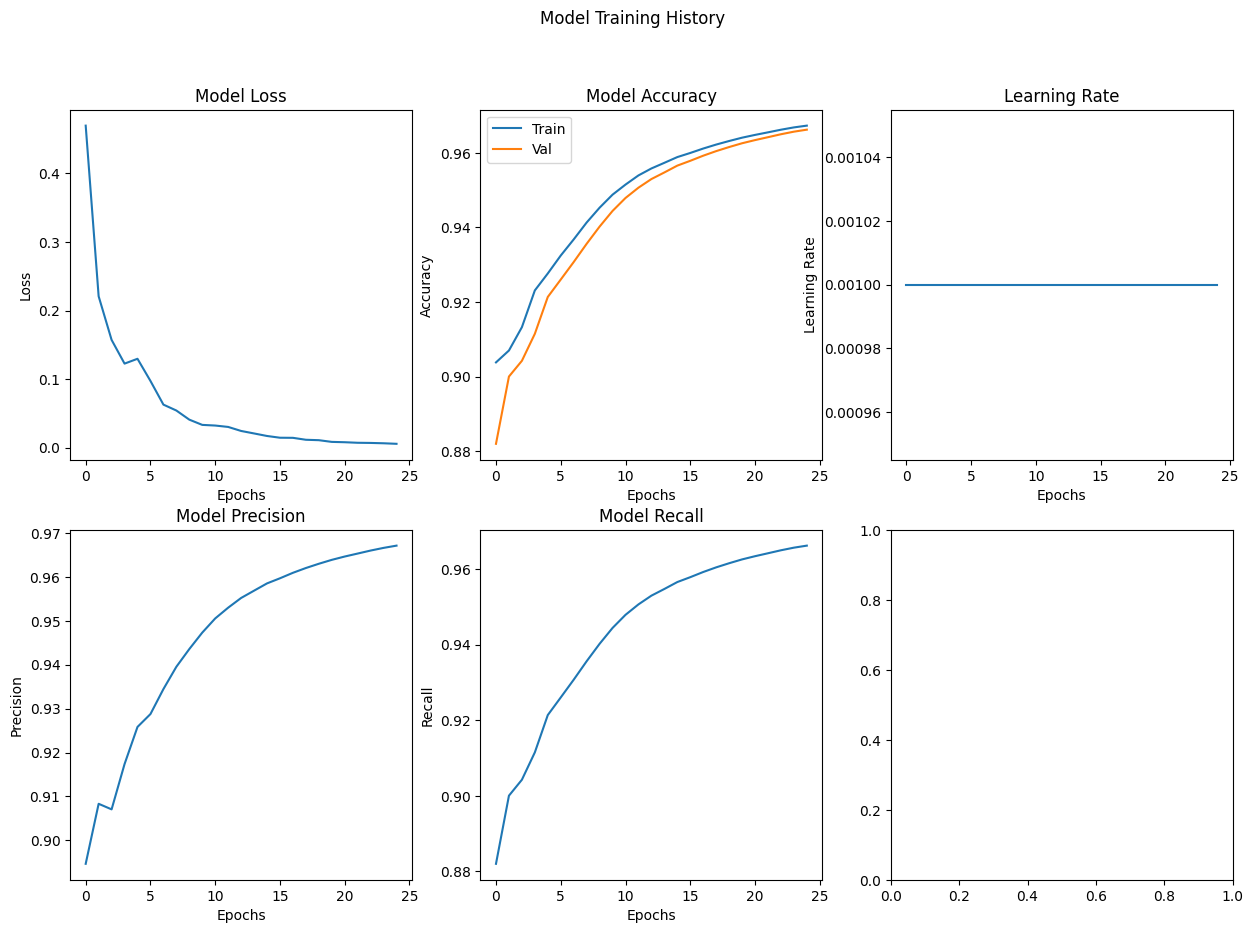

In [41]:
cnn.plot_history()

In [42]:
cnn.save_model()

## **Comparing Models**

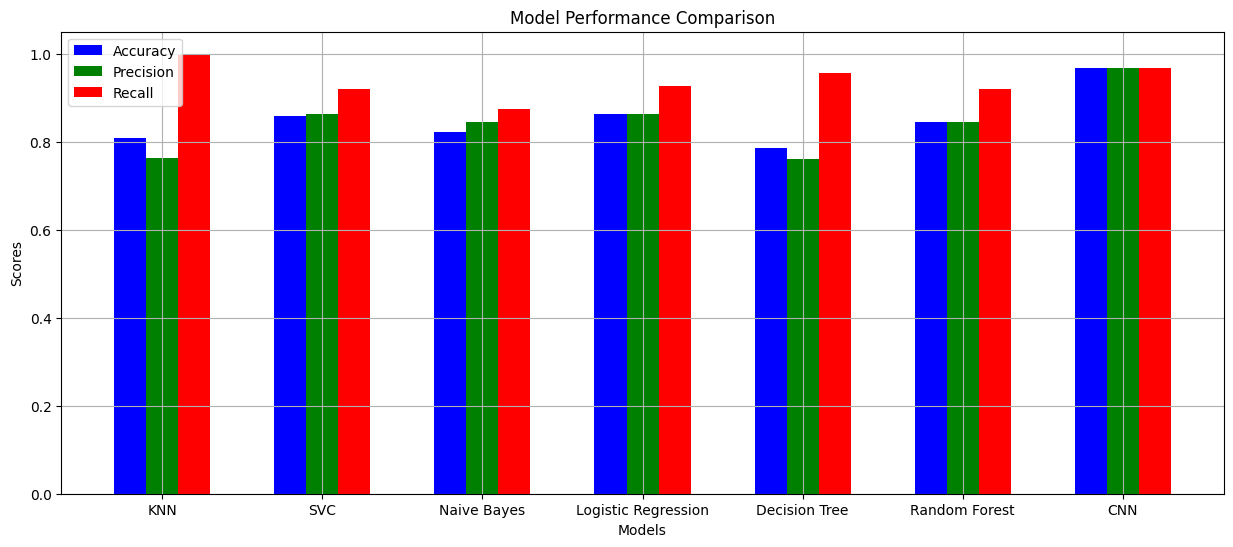

In [43]:
# plotting the accuracies
import matplotlib.pyplot as plt

models = ['KNN', 'SVC', 'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'CNN']
accuracies = [knn_accuracy, svc_accuracy, nb_accuracy, lr_accuracy, dt_accuracy, rf_accuracy, cnn_acc.to('cpu').item()]
precisions = [knn_precision, svc_precision, nb_precision, lr_precision, dt_precision, rf_precision, cnn_precision.to('cpu').item()]
recalls = [knn_recall, svc_recall, nb_recall, lr_recall, dt_recall, rf_recall, cnn_recall.to('cpu').item()]

x = range(len(models))

# Plotting accuracies
plt.figure(figsize=(15, 6))
plt.bar(x, accuracies, width=0.2, label='Accuracy', color='b', align='center')

# Plotting precisions
plt.bar([i + 0.2 for i in x], precisions, width=0.2, label='Precision', color='g', align='center')

# Plotting recalls
plt.bar([i + 0.4 for i in x], recalls, width=0.2, label='Recall', color='r', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks([i + 0.2 for i in x], models)
plt.legend()
plt.grid(True)
plt.show()
